# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1fFHfCy2vnlmR2i51g7pl8kS3zjhwWTwB#scrollTo=dSmtA8IaeUn3

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:02<00:00, 62458971.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

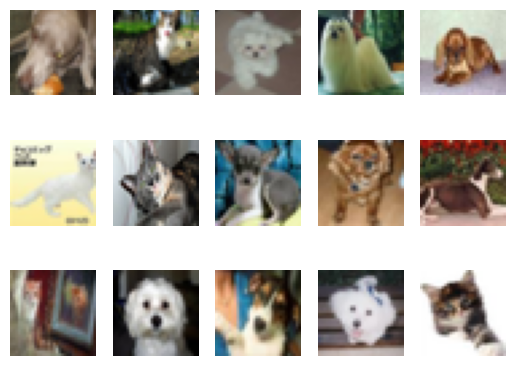

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

Running the code below, we have 8000 train examples, 2000 validation examples and 2000 test examples

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

A validation set is neccesary in the model training stages to ensure that our hyperparameters are tuned well before running our model through the test data. This validation set is used to see if our model is underfitted or overfitted to the 8000 training data samples. If we judge the performance of our models using the training set loss/error we run the risk of proceeding with a model that is overfitted to the training data (essentially just memorizes the training data and cant generalize to new data).

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
num_small_params = 0
for param in small_net.parameters():
    num_small_params = num_small_params + param.numel()

print(num_small_params)

386


In [ ]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
num_large_params = 0
for param in large_net.parameters():
    num_large_params = num_large_params + param.numel()

print(num_large_params)

9705


In total, there are 386 trainable parameters in the small network and 9705 trainable parameters in the large network

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

Default `batch_size` is 64, default `learning_rate` is 0.01 and default `num_epochs` is 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42225, Train loss: 0.6763146624565125 |Validation err: 0.385, Validation loss: 0.6554463021457195
Epoch 2: Train err: 0.37, Train loss: 0.6451133151054382 |Validation err: 0.3875, Validation loss: 0.6566442400217056
Epoch 3: Train err: 0.350125, Train loss: 0.6293705143928527 |Validation err: 0.347, Validation loss: 0.6242026668041945
Epoch 4: Train err: 0.334125, Train loss: 0.615574200630188 |Validation err: 0.342, Validation loss: 0.6248664706945419
Epoch 5: Train err: 0.325, Train loss: 0.6090328145027161 |Validation err: 0.3335, Validation loss: 0.6179555058479309
Finished Training
Total time elapsed: 20.90 seconds


In total, there are 9 files written to disk.


*   **model_small_bs64_lr0.01_epoch0** -- saves model parameters during epoch 1 to a file
*   **model_small_bs64_lr0.01_epoch1** -- saves model parameters during epoch 2 to a file
*   **model_small_bs64_lr0.01_epoch2** -- saves model parameters during epoch 3 to a file
*   **model_small_bs64_lr0.01_epoch3** -- saves model parameters during epoch 4 to a file
*   **model_small_bs64_lr0.01_epoch4** -- saves model parameters during epoch 5 to a file

*   **model_small_bs64_lr0.01_epoch4_train_err.csv** -- saves/records train error values at the end of each of the 5 epochs in a .csv file
*   **model_small_bs64_lr0.01_epoch4_train_loss.csv** -- saves/records train loss values at the end of each of the 5 epochs in a .csv file
*  **model_small_bs64_lr0.01_epoch4_val_err.csv** -- saves/records validation error values at the end of each of the 5 epochs in a .csv file
*   **model_small_bs64_lr0.01_epoch4_val_loss.csv** -- saves/records validation loss values at the end of each of the 5 epochs in a .csv file



### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.318125, Train loss: 0.5985729036331177 |Validation err: 0.3225, Validation loss: 0.613682808354497
Epoch 2: Train err: 0.312625, Train loss: 0.5907297081947327 |Validation err: 0.334, Validation loss: 0.6256326884031296
Epoch 3: Train err: 0.308125, Train loss: 0.5844725451469421 |Validation err: 0.3135, Validation loss: 0.5997884105890989
Epoch 4: Train err: 0.2975, Train loss: 0.5768431069850921 |Validation err: 0.3295, Validation loss: 0.6148678231984377
Epoch 5: Train err: 0.2975, Train loss: 0.5723840892314911 |Validation err: 0.3115, Validation loss: 0.604182904586196
Epoch 6: Train err: 0.291, Train loss: 0.5646916544437408 |Validation err: 0.3055, Validation loss: 0.5996946636587381
Epoch 7: Train err: 0.28675, Train loss: 0.5616825106143951 |Validation err: 0.3135, Validation loss: 0.5892399977892637
Epoch 8: Train err: 0.283875, Train loss: 0.5576236791610718 |Validation err: 0.2

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.443625, Train loss: 0.6865162806510925 |Validation err: 0.4155, Validation loss: 0.6732311751693487
Epoch 2: Train err: 0.4095, Train loss: 0.6731298127174378 |Validation err: 0.4225, Validation loss: 0.6795222740620375
Epoch 3: Train err: 0.389, Train loss: 0.6606341500282288 |Validation err: 0.3745, Validation loss: 0.645333781838417
Epoch 4: Train err: 0.363625, Train loss: 0.6405478205680847 |Validation err: 0.3675, Validation loss: 0.6361171193420887
Epoch 5: Train err: 0.345, Train loss: 0.6236972060203553 |Validation err: 0.338, Validation loss: 0.6147973537445068
Epoch 6: Train err: 0.339, Train loss: 0.6124280633926391 |Validation err: 0.3365, Validation loss: 0.6134774070233107
Epoch 7: Train err: 0.32625, Train loss: 0.6028217568397521 |Validation err: 0.3255, Validation loss: 0.5979955345392227
Epoch 8: Train err: 0.309375, Train loss: 0.5863556282520295 |Validation err: 0.326,

`small_net` took 139.27 seconds to train and `large_net` took 147.95 seconds to train. This increase in time is most likely due to the fact that `large_net` contains more trainable parameters that need to be updated.



### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

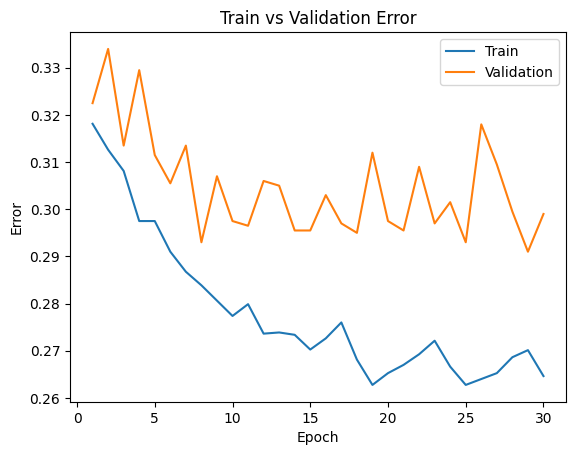

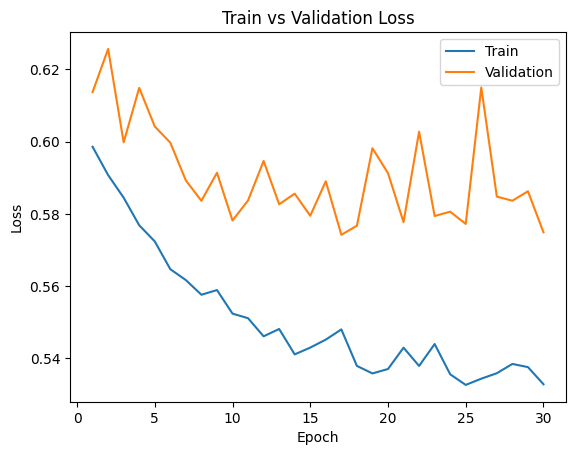

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

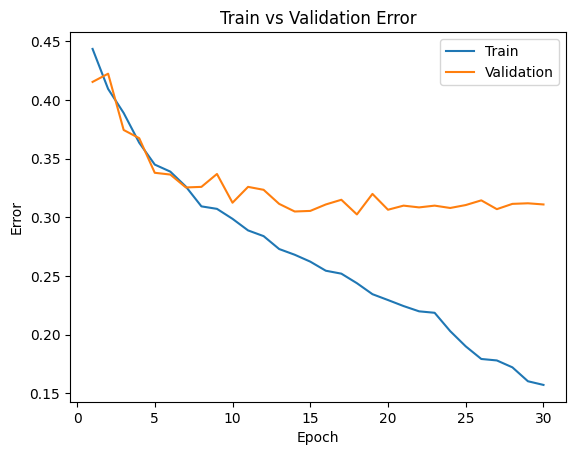

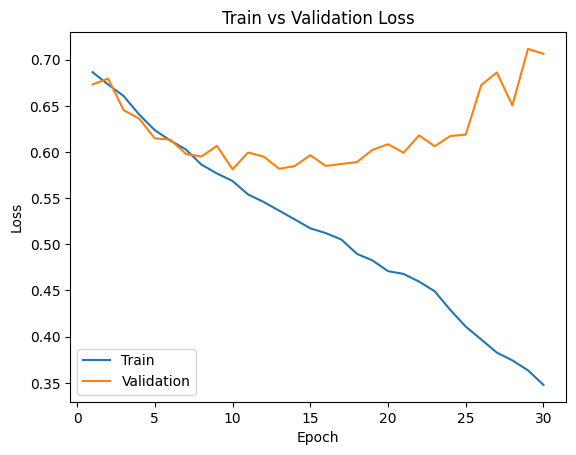

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The training curves for both `small_net` and `large_net` appear that they will approach 0 loss/error as the number of epochs increases. This is because at some number of epochs, the models will essentially 'memorize' the train data. This will occur more quickly (at a smaller # of epochs) for the `large_net` model, probably because it has more parameters (resulting in a more capable model). Also, it appears that the `large_net` has a more smooth downward trending training curve, with not as much variation/noise from epoch to epoch. This is also probably because of the fact that `large_net` is a more capable/powerful model. In terms of overfitting, we do see an evident case of overfitting in the `large_net` model, as by about epoch 10, we see that the validation error/loss curve starts decreasing at a much less rate compared to the training curve. By about epoch 20, we actually see the validation error increase, which also confirms that our `large_net` model is overfitting. it is harder to tell if the `small_net` model is overfitting because the differing rates of change between the training and validation curves are not as noticable, but it does appear that as the training error and loss slowly decreases, the validation loss/error is staying the same for the most part. This means even as the number of epochs increases, both models cannot generalize well to the validation data.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

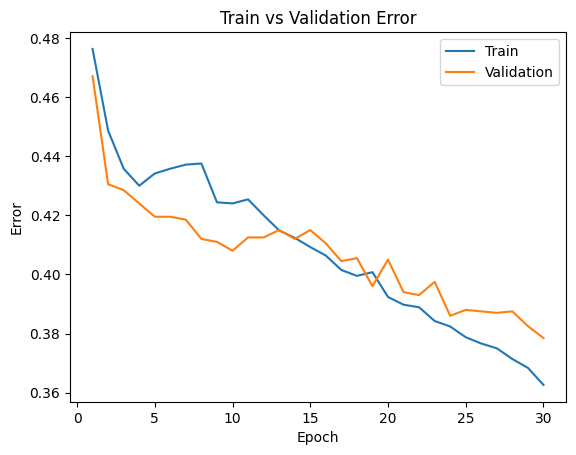

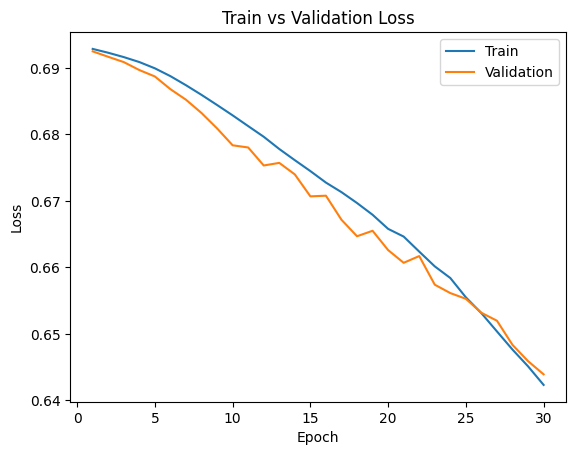

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

path = get_model_name('large', batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(path)


When lowering the learning rate to 0.001, the large model takes *longer* to train. This is due to the fact that the learning rate is smaller, which means that each step in the gradient descent optimization is smaller, as the updates to the parameters will occur more slowly. However, by looking at our plot, it seems that we have potentially eliminated the overfitting that occured when the learning rate was 0.01, as we see that the validation curve essentially mimics the training curve. Because we dont see a plateau in the training and valitation curve as # epochs increases, we have most likely When the learning rate is 0.01, we run the risk of accidentaly missing the identification of a local minima point (to minimize error), but with the lower learning rate we can more reliably identify these local minimas, to decrease error as much as possible.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

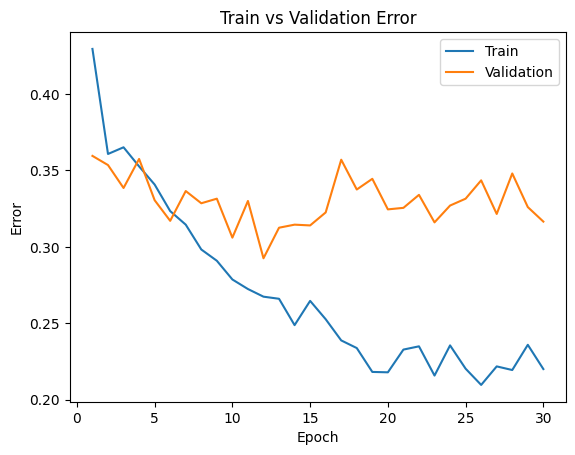

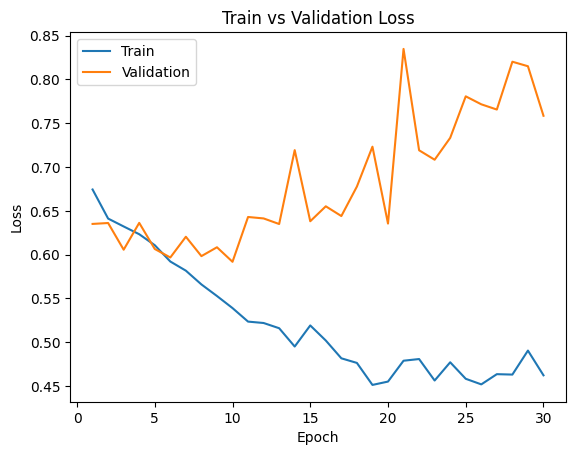

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

path = get_model_name('large', batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(path)


With the learning rate set to 0.1, we observe the opposite of what happened in part a). The model takes shorter to train compared to when using the default parameters, because we take larger 'steps' during gradient descent and converge to an estimated local minima too quickly. This actually leads to overfitting the model more quickly, as by about epoch 5, the training and validation curves start to diverge, and the validation curve actually increases slightly.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

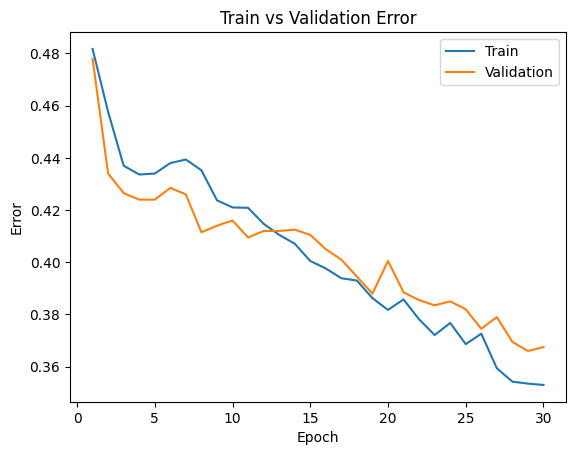

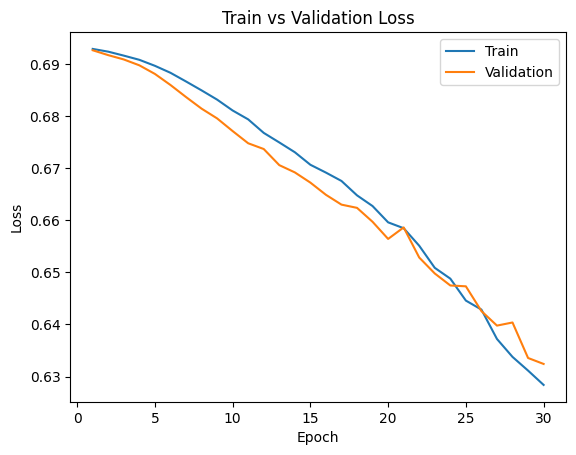

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512)

path = get_model_name('large', batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(path)


In this model, setting the batch size to 512 actually shortened the training time for 30 epochs. Furthermore, by looking at the plot we do not observe signs of overfitting, as the validation curve essentially mimics the training curve. When increasing the batch size to 512. Because we dont see a plateau in the training and valitation curve as # epochs increases, we have most likely underfit our date with these current parameters. The training time is less than the default model with batch size of 64 because when we increase the batch size, we decrease the number of iterations per epoch, which means less parameter updates in general. However, because each batch contains more images that the model can learn on, parameters are updated much more accurately upon each iteration, which is why we see that the model is not overfitting and is performing well.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

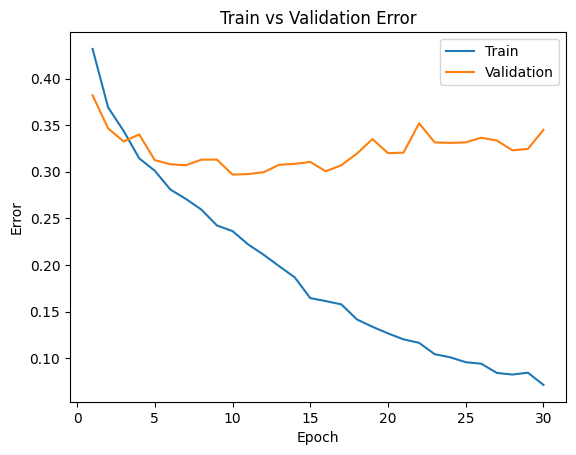

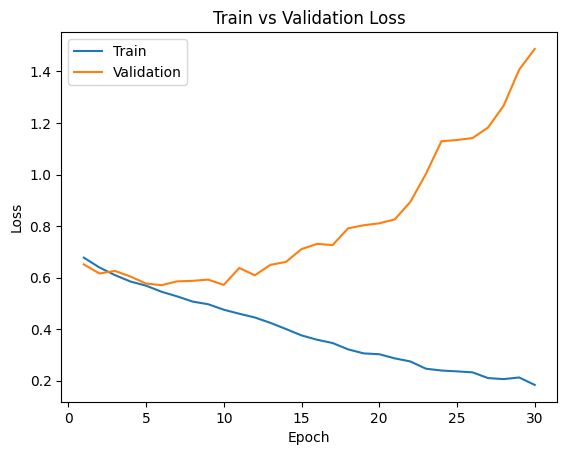

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16)

path = get_model_name('large', batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(path)

When using a batch size of 16, the model takes considerably longer to train, because of the fact that the parameters are updated more frequently with a smaller batch size (increased number of iterations). However, because these parameters are updating after only learning 16 samples, the updates to the parameters are inaccurate, and we see a severe case of overfitting in the generated plot, as the overfitting starts at epoch 5.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on my observations above, I will use the large model (more tunable parameters means a more powerful model), with a learning rate of 0.001 and a batch size of 512 for 30 epochs. These two parameter value choices performed the best alone, so I will use both at the same time.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677555501461 |Validation err: 0.4955, Validation loss: 0.6931361854076385
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360347032547
Epoch 3: Train err: 0.480375, Train loss: 0.6929280385375023 |Validation err: 0.493, Validation loss: 0.6929539740085602
Epoch 4: Train err: 0.477, Train loss: 0.6928808502852917 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.6927744261920452 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551908254623
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435587763786 |Validation err: 0.463, V

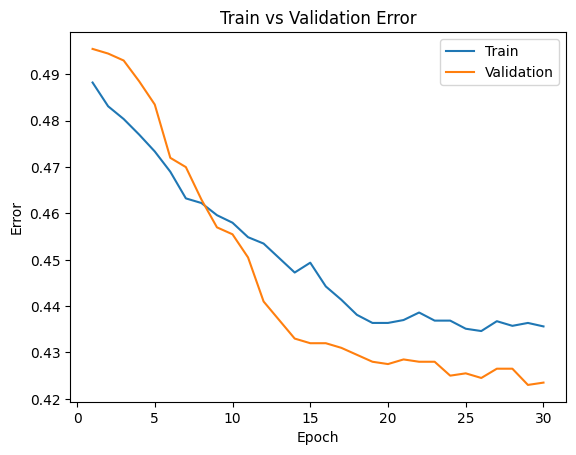

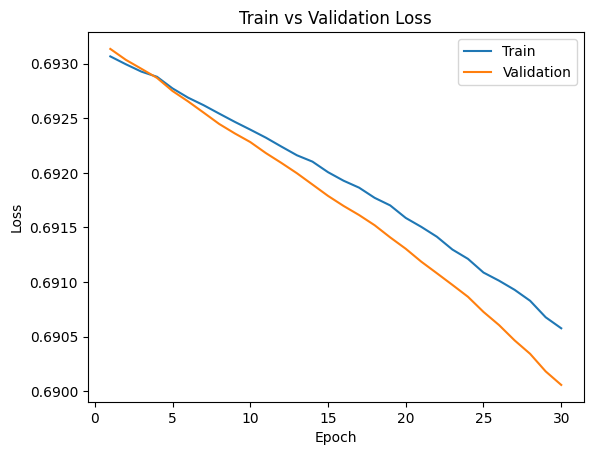

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.001)

path = get_model_name('large', batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

I will continue to use a batch size of 512, but I will increase the learning rate to 0.01, but increase the number of epochs to 100. I will choose to do this because it seems that the model is underfitting with 30 epochs as we achieve a minimum error of 0.43 with is considerably high. I believe that increasing the learning rate to 0.01 with a batch size this large will not lead to overfitting. Using a bigger learning rate will speed up the training process as well.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

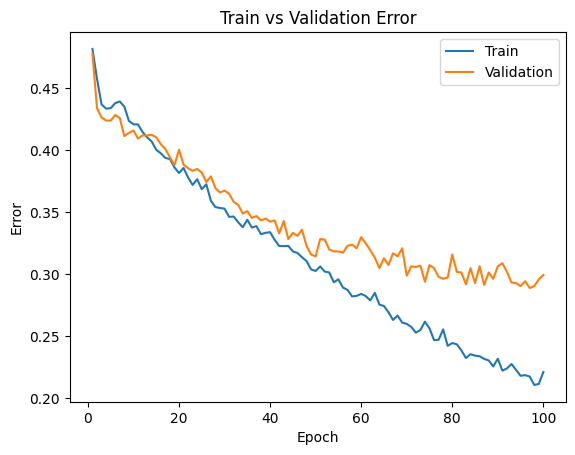

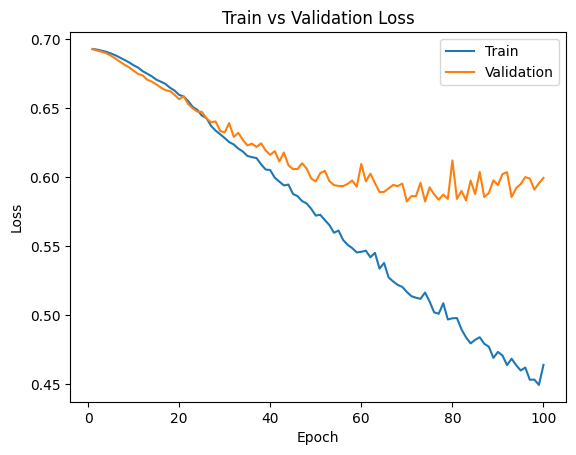

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=100)

path = get_model_name('large', batch_size=512, learning_rate=0.01, epoch=99)
plot_training_curve(path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=50)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose the parameters and model type in part (a) that work to minimize under/overfitting while also keeping the train time to a reasonable amount. My model in part 4(d) was performing decently until about epoch 50, where it started to overfit. The model is still underfit at this checkpoint, but it was the best I could do. These model parameters give me the lowest train error rate (around 0.32) before starting to overfit, while also keeping train times reasonable.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)

#using the evaluate(..) helper function in Part 0.
criterion = nn.BCEWithLogitsLoss()
testErr, testLoss = evaluate(net, test_loader, criterion)
print("Test Error: " + str(testErr * 100) + "%")

Files already downloaded and verified
Files already downloaded and verified
Test Error: 32.05%


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error is actually slightly less than the validation error. This is not what I was expecting, as I expected the opposite because the model has seen the validation set beforehand and parameters have been tuned using this set. The test set is data that has never been seen by the model, so it is expected that the test error is higher than the validation error.

In [ ]:
criterion = nn.BCEWithLogitsLoss()
valErr, valLoss = evaluate(net, val_loader, criterion)
print("Validation Error: " + str(valErr * 100) + "%")

Validation Error: 32.85%


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only use the test data set at the very end when the model is trained and all hyperparameters are tuned. This is because we want to show this model never before seen data, to test if it can generalize well. We want to use the test data as little as possible during the training stage because the whole point of training is to create a model that can generalize well to new data, so we can use this test data set to truly see the strength of our trained model.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.472875, Train loss: 0.691320464015007 |Validation err: 0.4315, Validation loss: 0.6796548217535019
Epoch 2: Train err: 0.411625, Train loss: 0.6713061667978764 |Validation err: 0.4235, Validation loss: 0.6699597239494324
Epoch 3: Train err: 0.397125, Train loss: 0.6628866381943226 |Validation err: 0.4035, Validation loss: 0.6650110185146332
Epoch 4: Train err: 0.39175, Train loss: 0.6561244390904903 |Validation err: 0.4025, Validation loss: 0.6603133231401443
Epoch 5: Train err: 0.37775, Train loss: 0.6506345681846142 |Validation err: 0.395, Validation loss: 0.6576936095952988
Epoch 6: Train err: 0.375125, Train loss: 0.6468521393835545 |Validation err: 0.3925, Validation loss: 0.6547654569149017
Epoch 7: Train err: 0.373, Train loss: 0.6424416117370129 |Validation err: 0.389, Validation loss: 0.6533641815185547
Epoch 8: Train err: 0.365875, Train loss: 0.6384049318730831 |Validation err: 

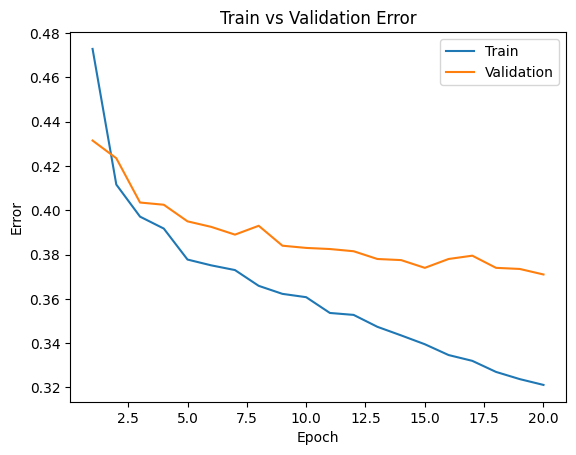

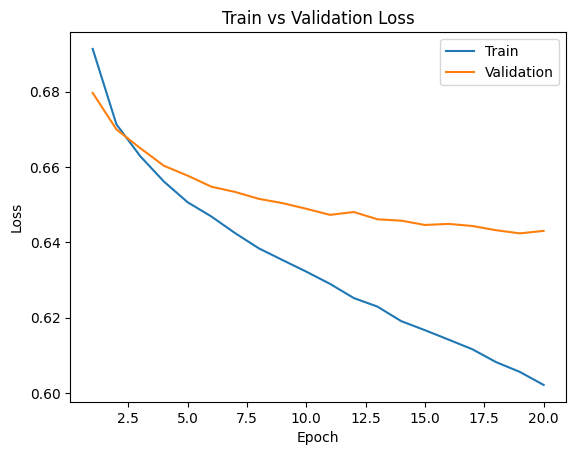

Files already downloaded and verified
Files already downloaded and verified
Test Error: 35.15%


In [ ]:
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 200)
        self.layer2 = nn.Linear(200, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

ANN = Pigeon()

train_net(ANN, batch_size=512, learning_rate=0.005, num_epochs=20)
model_path = get_model_name("ANN", batch_size=512, learning_rate=0.005, epoch=19)
plot_training_curve(model_path)

ANNtrain_loader, ANNval_loader, ANNtest_loader, ANNclasses = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

ANNcriterion = nn.BCEWithLogitsLoss()
ANNtestErr, ANNtestLoss = evaluate(ANN, ANNtest_loader, ANNcriterion)
print("Test Error: " + str(ANNtestErr * 100) + "%")

My best CNN model achieved a test error rate of 32.05%, and after tuning paramaters on this 2-layer ANN, I was able to achieve a test error rate of 35.15%. This drop off in performance is to be expected, as a 2-layer ANN is far too shallow to capture image complexities that a CNN can.

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab2_Cats_vs_Dogs.ipynb"

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 1783410 bytes to /content/Lab2_Cats_vs_Dogs.html
